In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_72472/6524477.py:12: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [ ]:
import pickle
from typing import Any

from flaml import AutoML
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import FixedThresholdClassifier, StratifiedKFold
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from hr_model import HrModel
from util import FeatureSetDataFrames


def specificity(y_true, y_pred) -> float:
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


def tune_threshold_ref_precision(model, X, y, *, verbose=False) -> float:
    hr_model = HrModel()

    ref_y_pred = hr_model.predict(X)
    ref_precision = precision_score(y, ref_y_pred, zero_division=np.nan)
    ref_recall = recall_score(y, ref_y_pred, zero_division=np.nan)

    y_pred_proba = model.predict_proba(X)

    thresholds = np.logspace(-10, 0, 100)
    for th in thresholds:
        y_pred = (y_pred_proba[:, 1] >= th).astype(int)
        precision = precision_score(y, y_pred, zero_division=np.nan)
        recall = recall_score(y, y_pred, zero_division=np.nan)
        if precision >= ref_precision:
            if verbose:
                print(f"Selected threshold: {th}")
                print(f"Selected precision: {precision}, recall: {recall}")
                print(f"Reference precision: {ref_precision}, recall: {ref_recall}")
            return th

    print(
        f"WARNING: Unable to improve on reference precision, using threshold of {thresholds[0]}!"
    )
    return thresholds[0]


def tune_threshold_ref_precision_cv(model, X, y, n_splits: int, verbose=False) -> float:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th = tune_threshold_ref_precision(model, X_val, y_val, verbose=verbose)
        thresholds.append(th)
    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")
    return best_threshold


def tune_threshold_youden(model, X, y, *, verbose=False) -> float:
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    youden_index = tpr - fpr
    best_threshold_index = np.argmax(youden_index)
    best_threshold = thresholds[best_threshold_index]

    if y.sum() == 0:
        raise ValueError("No positive samples in y.")

    if verbose:
        print(f"Best threshold: {best_threshold:.4f}")
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

    return best_threshold


def tune_threshold_youden_cv(model, X, y, n_splits, verbose=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th = tune_threshold_youden(model, X_val, y_val, verbose=verbose)
        thresholds.append(th)
    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")
    return best_threshold


def train_model(df_train, hyperparams: dict[str, Any]) -> FixedThresholdClassifier:
    X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
    model = XGBClassifier(**hyperparams)
    model.fit(X_train, y_train)
    threshold = tune_threshold_ref_precision_cv(
        model, X_train, y_train, n_splits=5, verbose=False
    )
    tuned_model = FixedThresholdClassifier(model, threshold=threshold)
    return tuned_model


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def train_and_get_dyad_models(
    df_population: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    week: int,
    dyad_models: dict[str, FixedThresholdClassifier],
):
    min_week = df_test["therapy_week"].min()
    if week == min_week:
        return dyad_models

    new_dyad_models = {}
    bootstrap_level = df_test["dyad"].nunique()
    match mode:
        case "no_retrain":
            return dyad_models
        case "retrain_dyad":
            for dyad, dyad_df in tqdm(df_test.groupby("dyad"), leave=False):
                add_df = dyad_df[dyad_df["therapy_week"] < week]
                add_df = bootstrap(add_df, bootstrap_level)

                df_train_concat = pd.concat([df_population, add_df])
                new_dyad_models[dyad] = train_model(
                    df_train_concat, dyad_models[dyad].estimator.get_params()
                )
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(
    base_model, df_train: pd.DataFrame, df_test: pd.DataFrame, mode: str
) -> list[tuple[int, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    dyad_models = {d: base_model for d in df_test["dyad"].unique()}
    weekly_results = []
    weeks = df_test["therapy_week"].unique()
    weeks_iter = sorted(weeks[weeks >= 0])
    for week in tqdm(weeks_iter):
        dyad_models = train_and_get_dyad_models(
            df_train, df_test, mode, week, dyad_models=dyad_models
        )
        week_df = df_test[df_test["therapy_week"] == week]

        week_pred_proba = np.empty((0, 2))
        week_preds = np.array([])
        week_trues = np.array([])
        week_thresholds = np.array([])
        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = model.predict(X)

            week_pred_proba = np.concatenate([week_pred_proba, y_pred_proba])
            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])
            threshold = (
                model.threshold if isinstance(model, FixedThresholdClassifier) else 0.5
            )
            week_thresholds = np.append(week_thresholds, threshold)

        weekly_results.append(
            (week, week_pred_proba, week_preds, week_trues, week_thresholds)
        )
    return weekly_results


supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]
automl_settings = {
    "max_iter": 25,
    "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


def eval_model_on_feature_sets(
    supersets_to_test: list[list[str]],
    dfs: FeatureSetDataFrames,
    weeks: tuple[int, int],
    mode: str,
) -> dict[str, Any]:
    feature_supersets = {
        "watch": [
            "hr",
            "activity",
            "sleep",
            "stress",
            "overnight_hrv",
        ],
        "demographic": [
            "child_demo",
            "parent_demo",
        ],
        "medical": [
            "medical",
            "therapy",
        ],
    }
    feature_set_results = {}
    for supersets in supersets_to_test:
        features = [fs for superset in supersets for fs in feature_supersets[superset]]
        combined_df = pd.concat(
            [
                cleaned_dyads_dfs["index"],
                cleaned_dyads_dfs["response"],
            ]
            + [cleaned_dyads_dfs[fs] for fs in features],
            axis=1,
        )

        name = "_".join(supersets)
        print(f"Feature sets: {name}")

        combined_df = combined_df[
            (combined_df["therapy_week"].between(weeks[0], weeks[1]))
        ]
        df_train = combined_df[combined_df["Arm_Sham"]]
        df_test = combined_df[~combined_df["Arm_Sham"]]

        X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")

        automl = AutoML()
        automl.fit(X_train, y_train, **automl_settings)

        tuned_model: FixedThresholdClassifier = train_model(
            df_train, automl.best_config
        )
        results = retrain_and_predict(tuned_model, df_train, df_test, mode=mode)

        data_dir = Path("./intermediate_data")
        data_dir.mkdir(parents=True, exist_ok=True)
        with open(data_dir / f"{mode}_{name}_results.pkl", "wb") as f:
            pickle.dump(results, f)

        feature_set_results[name] = results
    return feature_set_results

In [22]:
weeks = (0, 15)

In [23]:
from sklearn.dummy import DummyClassifier

full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

positive_model = DummyClassifier(strategy="constant", constant=1).fit(X_train, y_train)
positive_model_results = retrain_and_predict(
    positive_model, full_df_train, full_df_test, mode="no_retrain"
)

hr_model_results = retrain_and_predict(
    HrModel(), full_df_train, full_df_test, mode="no_retrain"
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
no_retrain_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="no_retrain",
)

Feature sets: watch
[flaml.automl.logger: 01-21 14:52:11] {1752} INFO - task = classification
[flaml.automl.logger: 01-21 14:52:11] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 01-21 14:52:11] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-21 14:52:11] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-21 14:52:11] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-21 14:52:12] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 01-21 14:52:12] {2466} INFO -  at 0.9s,	estimator xgboost's best error=0.0257,	best estimator xgboost's best error=0.0257
[flaml.automl.logger: 01-21 14:52:12] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-21 14:52:12] {2466} INFO -  at 1.3s,	estimator xgboost's best error=0.0257,	best estimator xgboost's best error=0.0257
[flaml.automl.logger: 01-21 14:52:12] {2282} INFO -

  0%|          | 0/24 [00:00<?, ?it/s]

Feature sets: watch_demographic
[flaml.automl.logger: 01-21 14:52:31] {1752} INFO - task = classification
[flaml.automl.logger: 01-21 14:52:31] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 01-21 14:52:31] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-21 14:52:31] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-21 14:52:31] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-21 14:52:32] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 01-21 14:52:32] {2466} INFO -  at 1.3s,	estimator xgboost's best error=0.0253,	best estimator xgboost's best error=0.0253
[flaml.automl.logger: 01-21 14:52:32] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-21 14:52:32] {2466} INFO -  at 1.9s,	estimator xgboost's best error=0.0253,	best estimator xgboost's best error=0.0253
[flaml.automl.logger: 01-21 14:52:32] {

  0%|          | 0/24 [00:00<?, ?it/s]

Feature sets: watch_medical
[flaml.automl.logger: 01-21 14:52:51] {1752} INFO - task = classification
[flaml.automl.logger: 01-21 14:52:51] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 01-21 14:52:51] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-21 14:52:51] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-21 14:52:51] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-21 14:52:52] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 01-21 14:52:52] {2466} INFO -  at 1.2s,	estimator xgboost's best error=0.0251,	best estimator xgboost's best error=0.0251
[flaml.automl.logger: 01-21 14:52:52] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-21 14:52:52] {2466} INFO -  at 1.7s,	estimator xgboost's best error=0.0251,	best estimator xgboost's best error=0.0251
[flaml.automl.logger: 01-21 14:52:52] {2282

  0%|          | 0/24 [00:00<?, ?it/s]

Feature sets: watch_demographic_medical
[flaml.automl.logger: 01-21 14:53:13] {1752} INFO - task = classification
[flaml.automl.logger: 01-21 14:53:13] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 01-21 14:53:13] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-21 14:53:13] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-21 14:53:13] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-21 14:53:13] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 01-21 14:53:13] {2466} INFO -  at 1.7s,	estimator xgboost's best error=0.0253,	best estimator xgboost's best error=0.0253
[flaml.automl.logger: 01-21 14:53:13] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-21 14:53:14] {2466} INFO -  at 2.3s,	estimator xgboost's best error=0.0253,	best estimator xgboost's best error=0.0253
[flaml.automl.logger: 01-21 14:

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
retrain_dyad_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="retrain_dyad",
)

# Analysis


In [34]:
import pickle
from pathlib import Path

data_dir = Path("./intermediate_data")
retrain_dyad_results = {
    k: pickle.load(open(data_dir / f"retrain_dyad_{k}_results.pkl", "rb"))
    for k in [
        "watch",
        "watch_demographic",
        "watch_medical",
        "watch_demographic_medical",
    ]
}

In [37]:
no_retrain_results = {k: v[:16] for k, v in no_retrain_results.items()}
retrain_dyad_results = {k: v[:16] for k, v in retrain_dyad_results.items()}

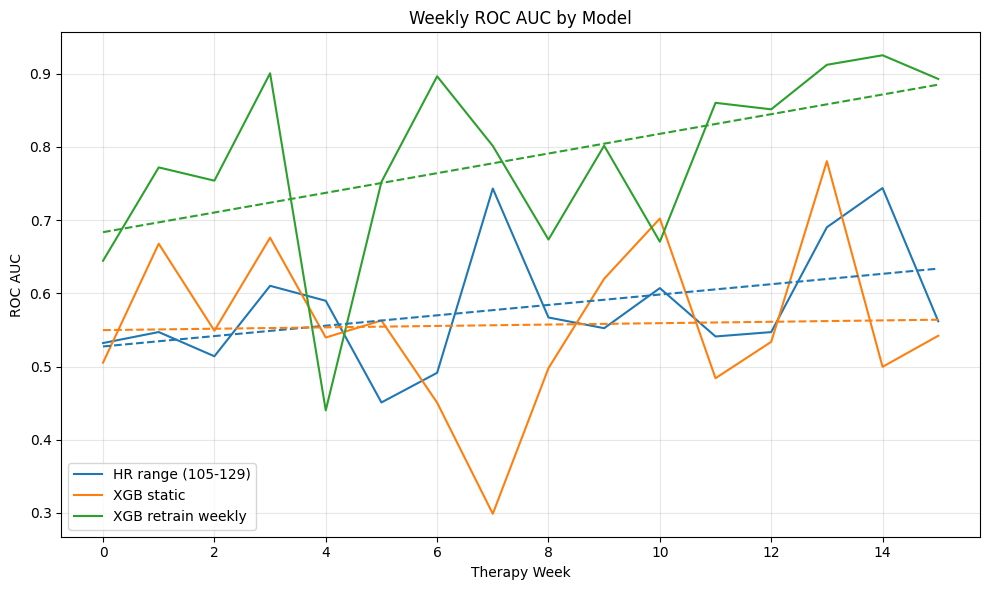

In [38]:
import matplotlib.pyplot as plt
import numpy as np


def get_weekly_roc_auc(results):
    aucs = []
    for week, y_pred_proba, _, y_true, _ in results:
        if len(set(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:
            auc = float("nan")
        aucs.append((week, auc))
    return aucs


hr_auc = get_weekly_roc_auc(hr_model_results)
no_retrain_auc = get_weekly_roc_auc(retrain_dyad_results["watch"])
retrain_auc = get_weekly_roc_auc(retrain_dyad_results["watch_demographic_medical"])

plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(*zip(*hr_auc), label="HR range (105-129)")
plt.plot(*zip(*no_retrain_auc), label="XGB static")
plt.plot(*zip(*retrain_auc), label="XGB retrain weekly")


# Add trendlines for each model
def plot_trendline(auc, color):
    weeks, values = zip(*auc)
    weeks = np.array(weeks)
    values = np.array(values)
    mask = ~np.isnan(values)
    if np.sum(mask) > 1:
        z = np.polyfit(weeks[mask], values[mask], 1)
        p = np.poly1d(z)
        plt.plot(weeks[mask], p(weeks[mask]), linestyle="--", color=color)


plot_trendline(hr_auc, "tab:blue")
plot_trendline(no_retrain_auc, "tab:orange")
plot_trendline(retrain_auc, "tab:green")

plt.xlabel("Therapy Week")
plt.ylabel("ROC AUC")
plt.title("Weekly ROC AUC by Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
import matplotlib.pyplot as plt
import numpy as np


# Ability to identify negative cases (true neg / predicted neg)
def specificity_score(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


metric = specificity_score


def plot_weekly_metric(metric_name, metric_fn):
    def weekly_metric(results):
        metrics = []
        for week, y_pred_proba, y_pred, y_true, _ in results:
            if len(set(y_true)) > 1:
                metric = metric_fn(y_true, y_pred)
            else:
                metric = float("nan")
            metrics.append((week, metric))
        return metrics

    hr_metric = weekly_metric(hr_model_results)
    no_retrain_metric = weekly_metric(no_retrain_results)
    retrain_metric = weekly_metric(retrain_dyad_results)

    plt.figure(figsize=(10, 6))

    # Plot lines
    plt.plot(*zip(*hr_metric), label="HR static (105-129)")
    plt.plot(*zip(*no_retrain_metric), label="XGB static")
    plt.plot(*zip(*retrain_metric), label="XGB retrain weekly")

    # Add trendlines for each model
    def plot_trendline(metric, color):
        weeks, values = zip(*metric)
        weeks = np.array(weeks)
        values = np.array(values)
        mask = ~np.isnan(values)
        if np.sum(mask) > 1:
            z = np.polyfit(weeks[mask], values[mask], 1)
            p = np.poly1d(z)
            plt.plot(weeks[mask], p(weeks[mask]), linestyle="--", color=color)

    plot_trendline(hr_metric, "tab:blue")
    plot_trendline(no_retrain_metric, "tab:orange")
    plot_trendline(retrain_metric, "tab:green")

    plt.xlabel("Therapy Week")
    plt.ylabel(f"{metric_name}")
    plt.title(f"Weekly {metric_name} by Model")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_weekly_metric("Sensitivity", recall_score)
plot_weekly_metric("Specificity", specificity_score)

ValueError: too many values to unpack (expected 5)

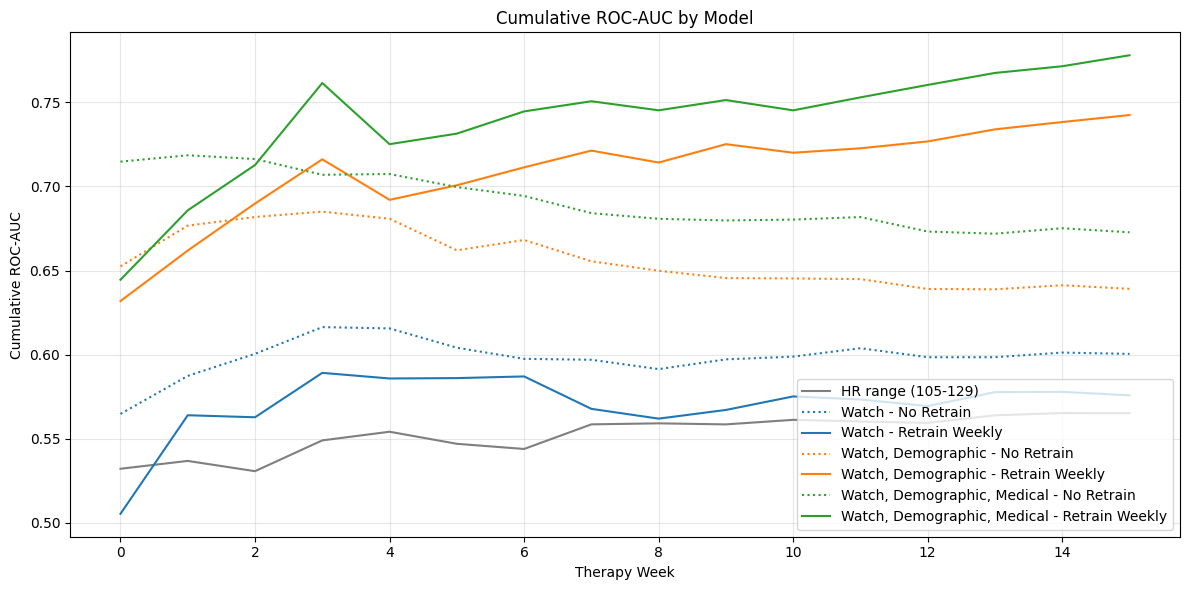

In [45]:
import numpy as np


def get_cumulative_roc_auc(results):
    aucs = []
    all_y_pred_proba = np.empty((0, 2))
    all_y_pred = np.array([])
    all_y_true = np.array([])
    for week, y_pred_proba, y_pred, y_true, _ in results:
        # For coin flip, y_pred_proba may contain -1, clip to [0, 1]
        all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
        all_y_pred = np.concatenate([all_y_pred, y_pred])
        all_y_true = np.concatenate([all_y_true, y_true])
        # Only compute if there are both classes present
        if len(set(all_y_true)) > 1:
            auc = roc_auc_score(all_y_true, all_y_pred_proba[:, 1])
        else:
            auc = float("nan")
        aucs.append((week, auc))
    return aucs


hr_cum_auc = get_cumulative_roc_auc(hr_model_results)
no_retrain_watch_cum_auc = get_cumulative_roc_auc(no_retrain_results["watch"])
no_retrain_demographic_cum_auc = get_cumulative_roc_auc(
    no_retrain_results["watch_demographic"]
)
no_retrain_medical_cum_auc = get_cumulative_roc_auc(
    no_retrain_results["watch_demographic_medical"]
)
retrain_watch_cum_auc = get_cumulative_roc_auc(retrain_dyad_results["watch"])
retrain_demographic_cum_auc = get_cumulative_roc_auc(
    retrain_dyad_results["watch_demographic"]
)
retrain_medical_cum_auc = get_cumulative_roc_auc(
    retrain_dyad_results["watch_demographic_medical"]
)


plt.figure(figsize=(12, 6))
plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")
plt.plot(*zip(*no_retrain_watch_cum_auc), label="Watch - No Retrain", linestyle=":")
plt.plot(*zip(*retrain_watch_cum_auc), label="Watch - Retrain Weekly", color="tab:blue")
plt.plot(
    *zip(*no_retrain_demographic_cum_auc),
    label="Watch, Demographic - No Retrain",
    linestyle=":",
)
plt.plot(
    *zip(*retrain_demographic_cum_auc),
    label="Watch, Demographic - Retrain Weekly",
    color="tab:orange",
)
plt.plot(
    *zip(*no_retrain_medical_cum_auc),
    label="Watch, Demographic, Medical - No Retrain",
    linestyle=":",
)
plt.plot(
    *zip(*retrain_medical_cum_auc),
    label="Watch, Demographic, Medical - Retrain Weekly",
    color="tab:green",
)
plt.xlabel("Therapy Week")
plt.ylabel("Cumulative ROC-AUC")
plt.title("Cumulative ROC-AUC by Model")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

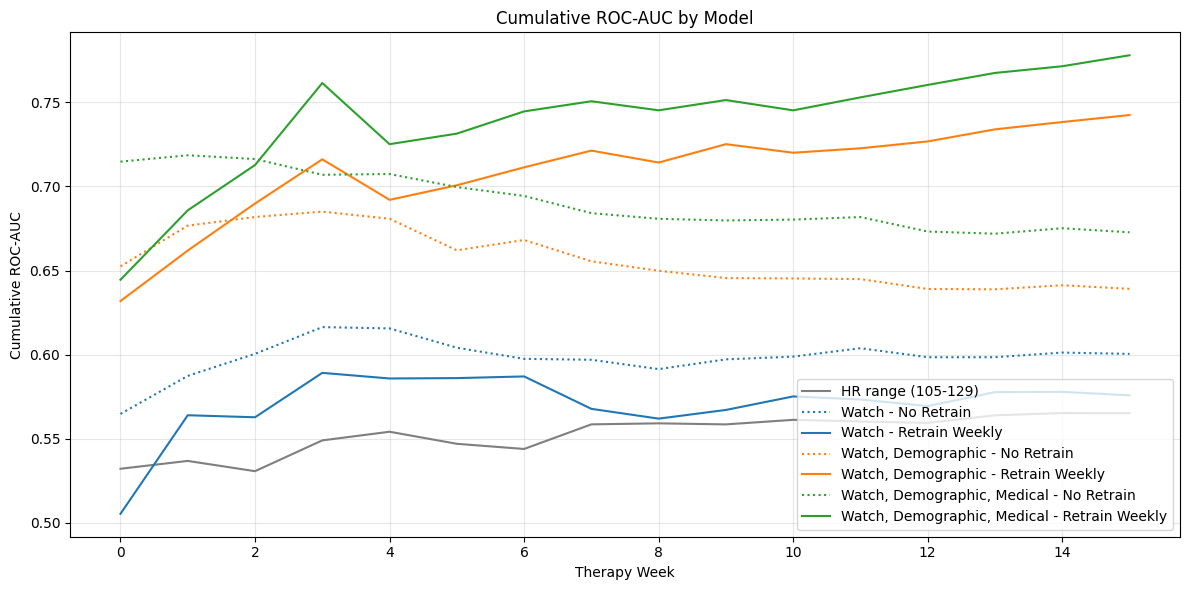

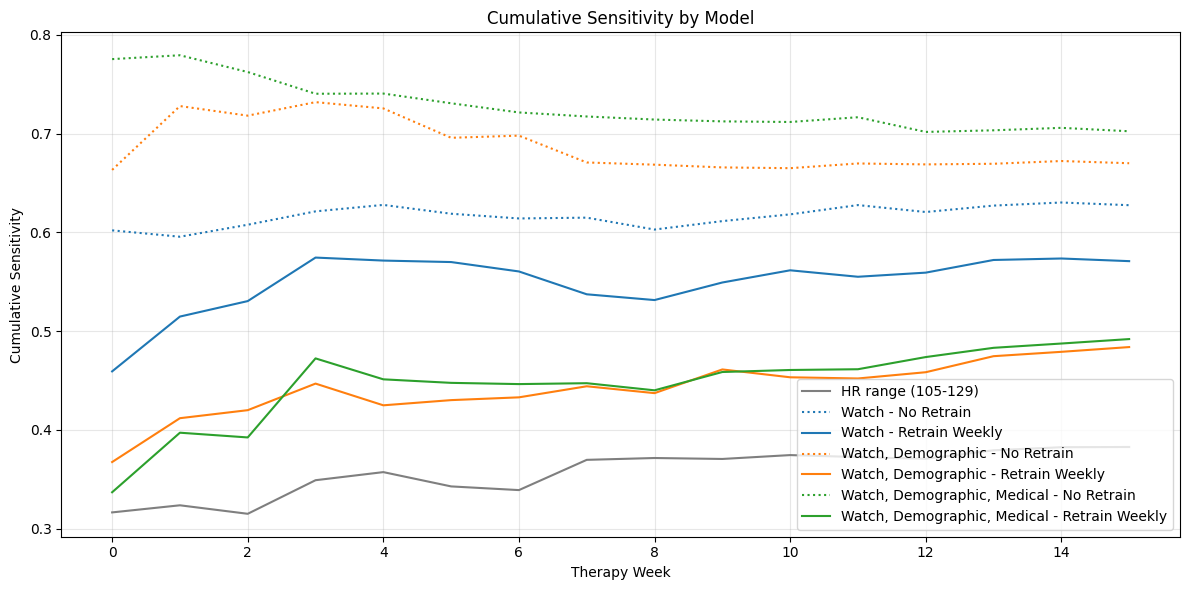

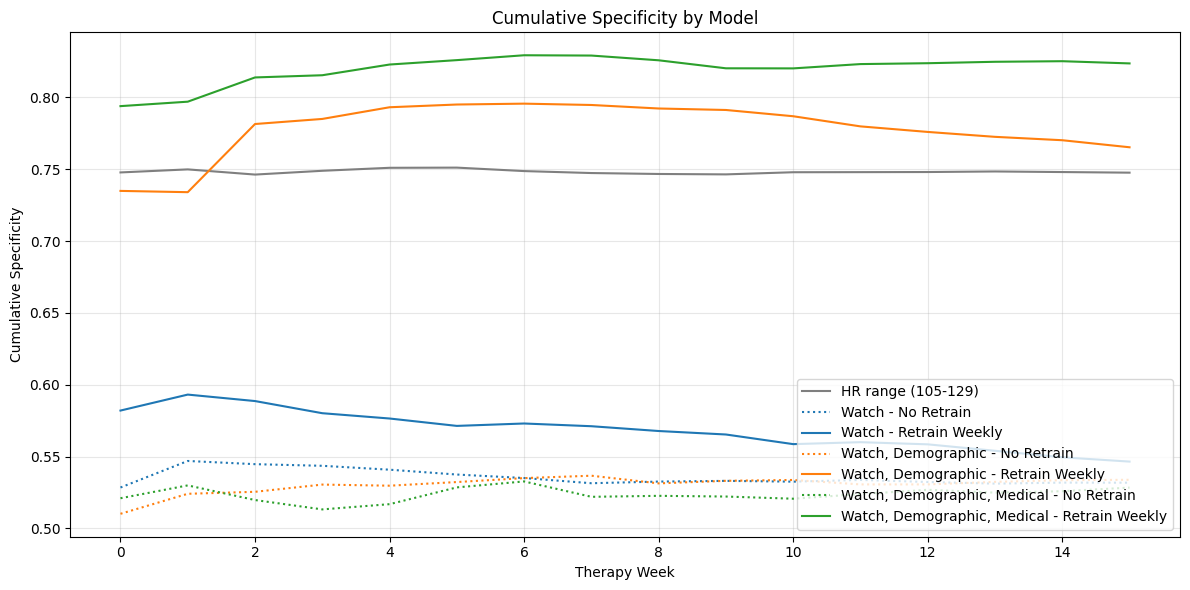

In [47]:
import numpy as np


def plot_weekly_cum_metric(metric_name, metric_fn):
    def weekly_cum_metric(results, metric_fn):
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
            # Only compute if there are both classes present

            if metric_fn is roc_auc_score:
                metric = metric_fn(all_y_true, all_y_pred_proba[:, 1])
            else:
                metric = metric_fn(all_y_true, all_y_pred)
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_watch_cum_auc = weekly_cum_metric(no_retrain_results["watch"], metric_fn)
    no_retrain_demographic_cum_auc = weekly_cum_metric(
        no_retrain_results["watch_demographic"], metric_fn
    )
    no_retrain_medical_cum_auc = weekly_cum_metric(
        no_retrain_results["watch_demographic_medical"], metric_fn
    )
    retrain_watch_cum_auc = weekly_cum_metric(retrain_dyad_results["watch"], metric_fn)
    retrain_demographic_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic"], metric_fn
    )
    retrain_medical_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic_medical"], metric_fn
    )

    plt.figure(figsize=(12, 6))
    plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")
    plt.plot(*zip(*no_retrain_watch_cum_auc), label="Watch - No Retrain", linestyle=":")
    plt.plot(
        *zip(*retrain_watch_cum_auc), label="Watch - Retrain Weekly", color="tab:blue"
    )
    plt.plot(
        *zip(*no_retrain_demographic_cum_auc),
        label="Watch, Demographic - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*retrain_demographic_cum_auc),
        label="Watch, Demographic - Retrain Weekly",
        color="tab:orange",
    )
    plt.plot(
        *zip(*no_retrain_medical_cum_auc),
        label="Watch, Demographic, Medical - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*retrain_medical_cum_auc),
        label="Watch, Demographic, Medical - Retrain Weekly",
        color="tab:green",
    )
    plt.xlabel("Therapy Week")
    plt.ylabel(f"Cumulative {metric_name}")
    plt.title(f"Cumulative {metric_name} by Model")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_weekly_cum_metric("ROC-AUC", roc_auc_score)
plot_weekly_cum_metric("Sensitivity", recall_score)
plot_weekly_cum_metric("Specificity", specificity_score)